In [32]:
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.feature import canny
from skimage.filters import gaussian

Aggressive Canny crop: (3165, 3702) -> (3165, 3702)
Aggressive Canny crop: (3165, 3702) -> (3165, 3702)
Aggressive Canny crop: (3165, 3702) -> (3165, 3702)


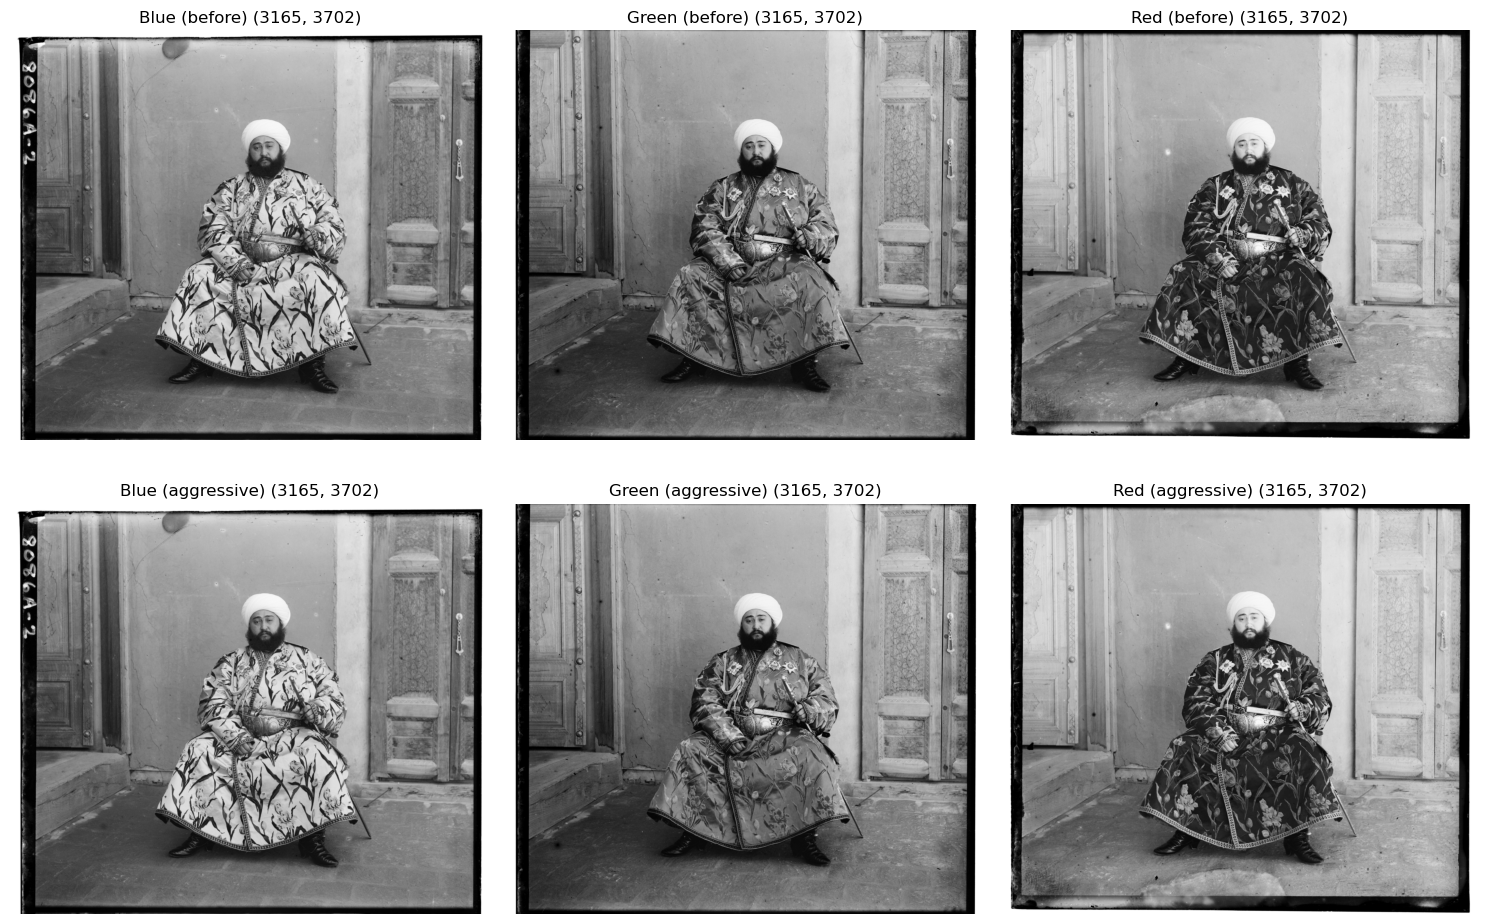

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], shape=(3165, 3702)),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], shape=(3165, 3702)),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], shape=(3165, 3702)))

In [36]:
def detect_borders_with_canny_tuned(channel, sigma=2.0, low_threshold=0.05, high_threshold=0.15, erosion_size=5):
    """
    More aggressive Canny edge detection with morphological operations
    """
    from skimage.morphology import binary_erosion, disk
    
    # Apply Canny with more sensitive parameters
    edges = canny(channel, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    
    # Apply morphological erosion to remove scattered edge pixels near borders
    if erosion_size > 0:
        edges = binary_erosion(edges, disk(erosion_size))
    
    # Find the bounding box of remaining edge content
    edge_rows, edge_cols = np.where(edges)
    
    if len(edge_rows) > 0 and len(edge_cols) > 0:
        top = edge_rows.min()
        bottom = edge_rows.max() + 1
        left = edge_cols.min()  
        right = edge_cols.max() + 1
        
        return top, bottom, left, right
    else:
        return 0, channel.shape[0], 0, channel.shape[1]

def crop_borders_aggressive_canny(channel, padding=20):
    """
    More aggressive Canny-based cropping
    """
    top, bottom, left, right = detect_borders_with_canny_tuned(
        channel, 
        sigma=15.0,           # More smoothing
        low_threshold=0.001,  # Lower threshold = more sensitive
        high_threshold=0.001,  # Lower threshold = more sensitive
        erosion_size=8       # Remove border noise
    )
    
    # Add conservative padding
    top = max(0, top - padding)
    bottom = min(channel.shape[0], bottom + padding)
    left = max(0, left - padding) 
    right = min(channel.shape[1], right + padding)
    
    cropped = channel[top:bottom, left:right]
    print(f"Aggressive Canny crop: {channel.shape} -> {cropped.shape}")
    
    return cropped

# Test with more aggressive parameters
def test_aggressive_canny(image_path):
    im = skio.imread(image_path)
    im = sk.img_as_float(im)
    
    cropped = im[50:-80]
    height = cropped.shape[0] // 3
    b = cropped[:height]
    g = cropped[height:2*height] 
    r = cropped[2*height:3*height]
    
    # Try aggressive Canny cropping
    b_agg = crop_borders_aggressive_canny(b, padding=30)
    g_agg = crop_borders_aggressive_canny(g, padding=30)
    r_agg = crop_borders_aggressive_canny(r, padding=30)
    
    # Show comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(b, cmap='gray')
    plt.title(f'Blue (before) {b.shape}')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(g, cmap='gray')
    plt.title(f'Green (before) {g.shape}')
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(r, cmap='gray')
    plt.title(f'Red (before) {r.shape}')
    plt.axis('off')
    
    plt.subplot(2, 3, 4)
    plt.imshow(b_agg, cmap='gray')
    plt.title(f'Blue (aggressive) {b_agg.shape}')
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    plt.imshow(g_agg, cmap='gray')
    plt.title(f'Green (aggressive) {g_agg.shape}')
    plt.axis('off')
    
    plt.subplot(2, 3, 6)
    plt.imshow(r_agg, cmap='gray')
    plt.title(f'Red (aggressive) {r_agg.shape}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return b_agg, g_agg, r_agg

test_aggressive_canny('/Users/junwei/Fall2025/CS180/iswagnacio.github.io/Proj1/emir.tif')

In [ ]:
def align_single_scale(channel_to_align, reference_channel, search_range=5):
    """
    Align channel_to_align to reference_channel using exhaustive search with NCC
    Returns: (best_dx, best_dy, aligned_channel)
    """
    best_score = -1  # For NCC, higher is better (range -1 to 1)
    best_displacement = (0, 0)

    margin = 60  # Adjust this value

    ref_inner = reference_channel[margin:-margin, margin:-margin]
    channel_inner = channel_to_align[margin:-margin, margin:-margin]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(ref_inner, cmap='gray')
    plt.title('Blue')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(channel_inner, cmap='gray')
    plt.title('Green/Red')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    for dx in range(-search_range, search_range + 1):
        for dy in range(-search_range, search_range + 1):
            shifted = np.roll(channel_to_align, dx, axis=1)
            shifted = np.roll(shifted, dy, axis=0)

            # Only compute metric on inner region (exclude borders)
            ref_inner = reference_channel[margin:-margin, margin:-margin]
            shifted_inner = shifted[margin:-margin, margin:-margin]

            # Compute Normalized Cross-Correlation (NCC)
            # Flatten arrays for easier computation
            ref_flat = ref_inner.flatten()
            shifted_flat = shifted_inner.flatten()
            
            # Subtract means (center the data)
            ref_centered = ref_flat - np.mean(ref_flat)
            shifted_centered = shifted_flat - np.mean(shifted_flat)
            
            # Compute normalized cross-correlation
            numerator = np.dot(ref_centered, shifted_centered)
            denominator = np.linalg.norm(ref_centered) * np.linalg.norm(shifted_centered)
            
            if denominator > 0:
                ncc_score = numerator / denominator
            else:
                ncc_score = -1  # Worst possible score
            
            # For NCC, higher values are better
            if ncc_score > best_score:
                best_score = ncc_score
                best_displacement = (dx, dy)

    print(f"Best NCC score: {best_score:.4f}")
    
    # Apply best displacement
    best_aligned = np.roll(channel_to_align, best_displacement[0], axis=1)
    best_aligned = np.roll(best_aligned, best_displacement[1], axis=0)

    return best_displacement[0], best_displacement[1], best_aligned

In [12]:
def colorize_image(image_path):
    # Read and convert image
    im = skio.imread(image_path)
    im = sk.img_as_float(im)

    # Split into BGR channels (top to bottom)
    height = im.shape[0] // 3
    b = im[:height]                    # Blue (reference)
    g = im[height:2*height]            # Green (align to blue)
    r = im[2*height:3*height]          # Red (align to blue)

    # Align G and R to B
    g_dx, g_dy, aligned_g = align_single_scale(g, b)
    r_dx, r_dy, aligned_r = align_single_scale(r, b)

    # Print displacements
    print(f"Green channel displacement: ({g_dx}, {g_dy})")
    print(f"Red channel displacement: ({r_dx}, {r_dy})")

    # Create RGB color image (note: BGR -> RGB conversion)
    color_image = np.dstack([aligned_r, aligned_g, b])
    skio.imshow(color_image)
    skio.show()

    return color_image

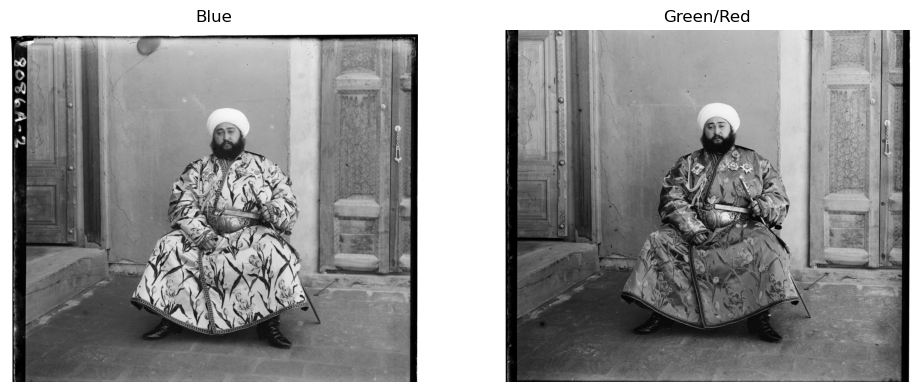

Best NCC score: 0.6068


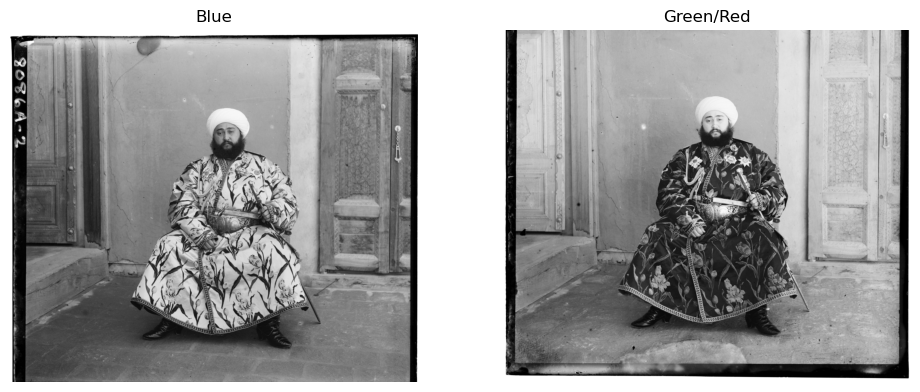

Best NCC score: 0.2997
Green channel displacement: (5, 5)
Red channel displacement: (5, 5)


/var/folders/f1/h8rqd2ts7wg6xp5372dxsg740000gn/T/ipykernel_7728/2798854859.py:22: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(color_image)
/var/folders/f1/h8rqd2ts7wg6xp5372dxsg740000gn/T/ipykernel_7728/2798854859.py:23: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


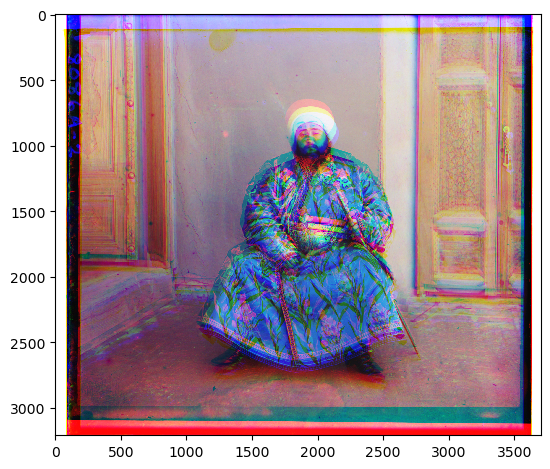

In [ ]:
color_image = colorize_image('/Users/junwei/Fall2025/CS180/iswagnacio.github.io/Proj1/emir.tif')